In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM

from code.dataset.probe import confidence_function_dataset
# import numpy as np
from code.repe import repe_pipeline_registry
from code.utils import *

repe_pipeline_registry()

rep-reading is already registered. Overwriting pipeline for task rep-reading...
rep-control is already registered. Overwriting pipeline for task rep-control...
rep-control is already registered. Overwriting pipeline for task rep-control...


In [3]:
model_name_or_path = "./model/Mistral-7B-Instruct-v0.1"

model = AutoModelForCausalLM.from_pretrained(
    model_name_or_path, torch_dtype=torch.float16, device_map="auto"
)
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False
)
tokenizer.pad_token_id = 0

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
rep_token = -1
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
n_difference = 1
direction_method = "pca"
rep_reading_pipeline = pipeline("rep-reading", model=model, tokenizer=tokenizer)

In [9]:
user_tag = "[INST]"
assistant_tag = "[/INST]"

data_path = (
    "./eval_data/confidence_train.csv"
)
dataset = confidence_function_dataset(
    data_path,
    tokenizer,
    user_tag,
    512,
    assistant_tag,
    pos_tag="a confident",
    neg_tag="an unconfident",
    prompt_type="1",
)

Train data: 1024
Eval data: 512
Test data: 299


In [19]:
# train the probe from scratch
confidence_rep_reader = rep_reading_pipeline.get_directions(
    dataset['train']['data'],
    rep_token=rep_token,
    hidden_layers=hidden_layers,
    n_difference=n_difference,
    train_labels=dataset['train']['labels'],
    direction_method=direction_method,
    batch_size=32,
)

# directly load the probe
# import pickle
# with open('./trained_probe/confidence/02_26_25/model_file/rep_reader.pkl', 'rb') as file:
#     confidence_rep_reader = pickle.load(file)

# save the trained probe
# import pickle
# with open('conf_probe.pkl', 'wb') as file:
#     pickle.dump(confidence_rep_reader, file)

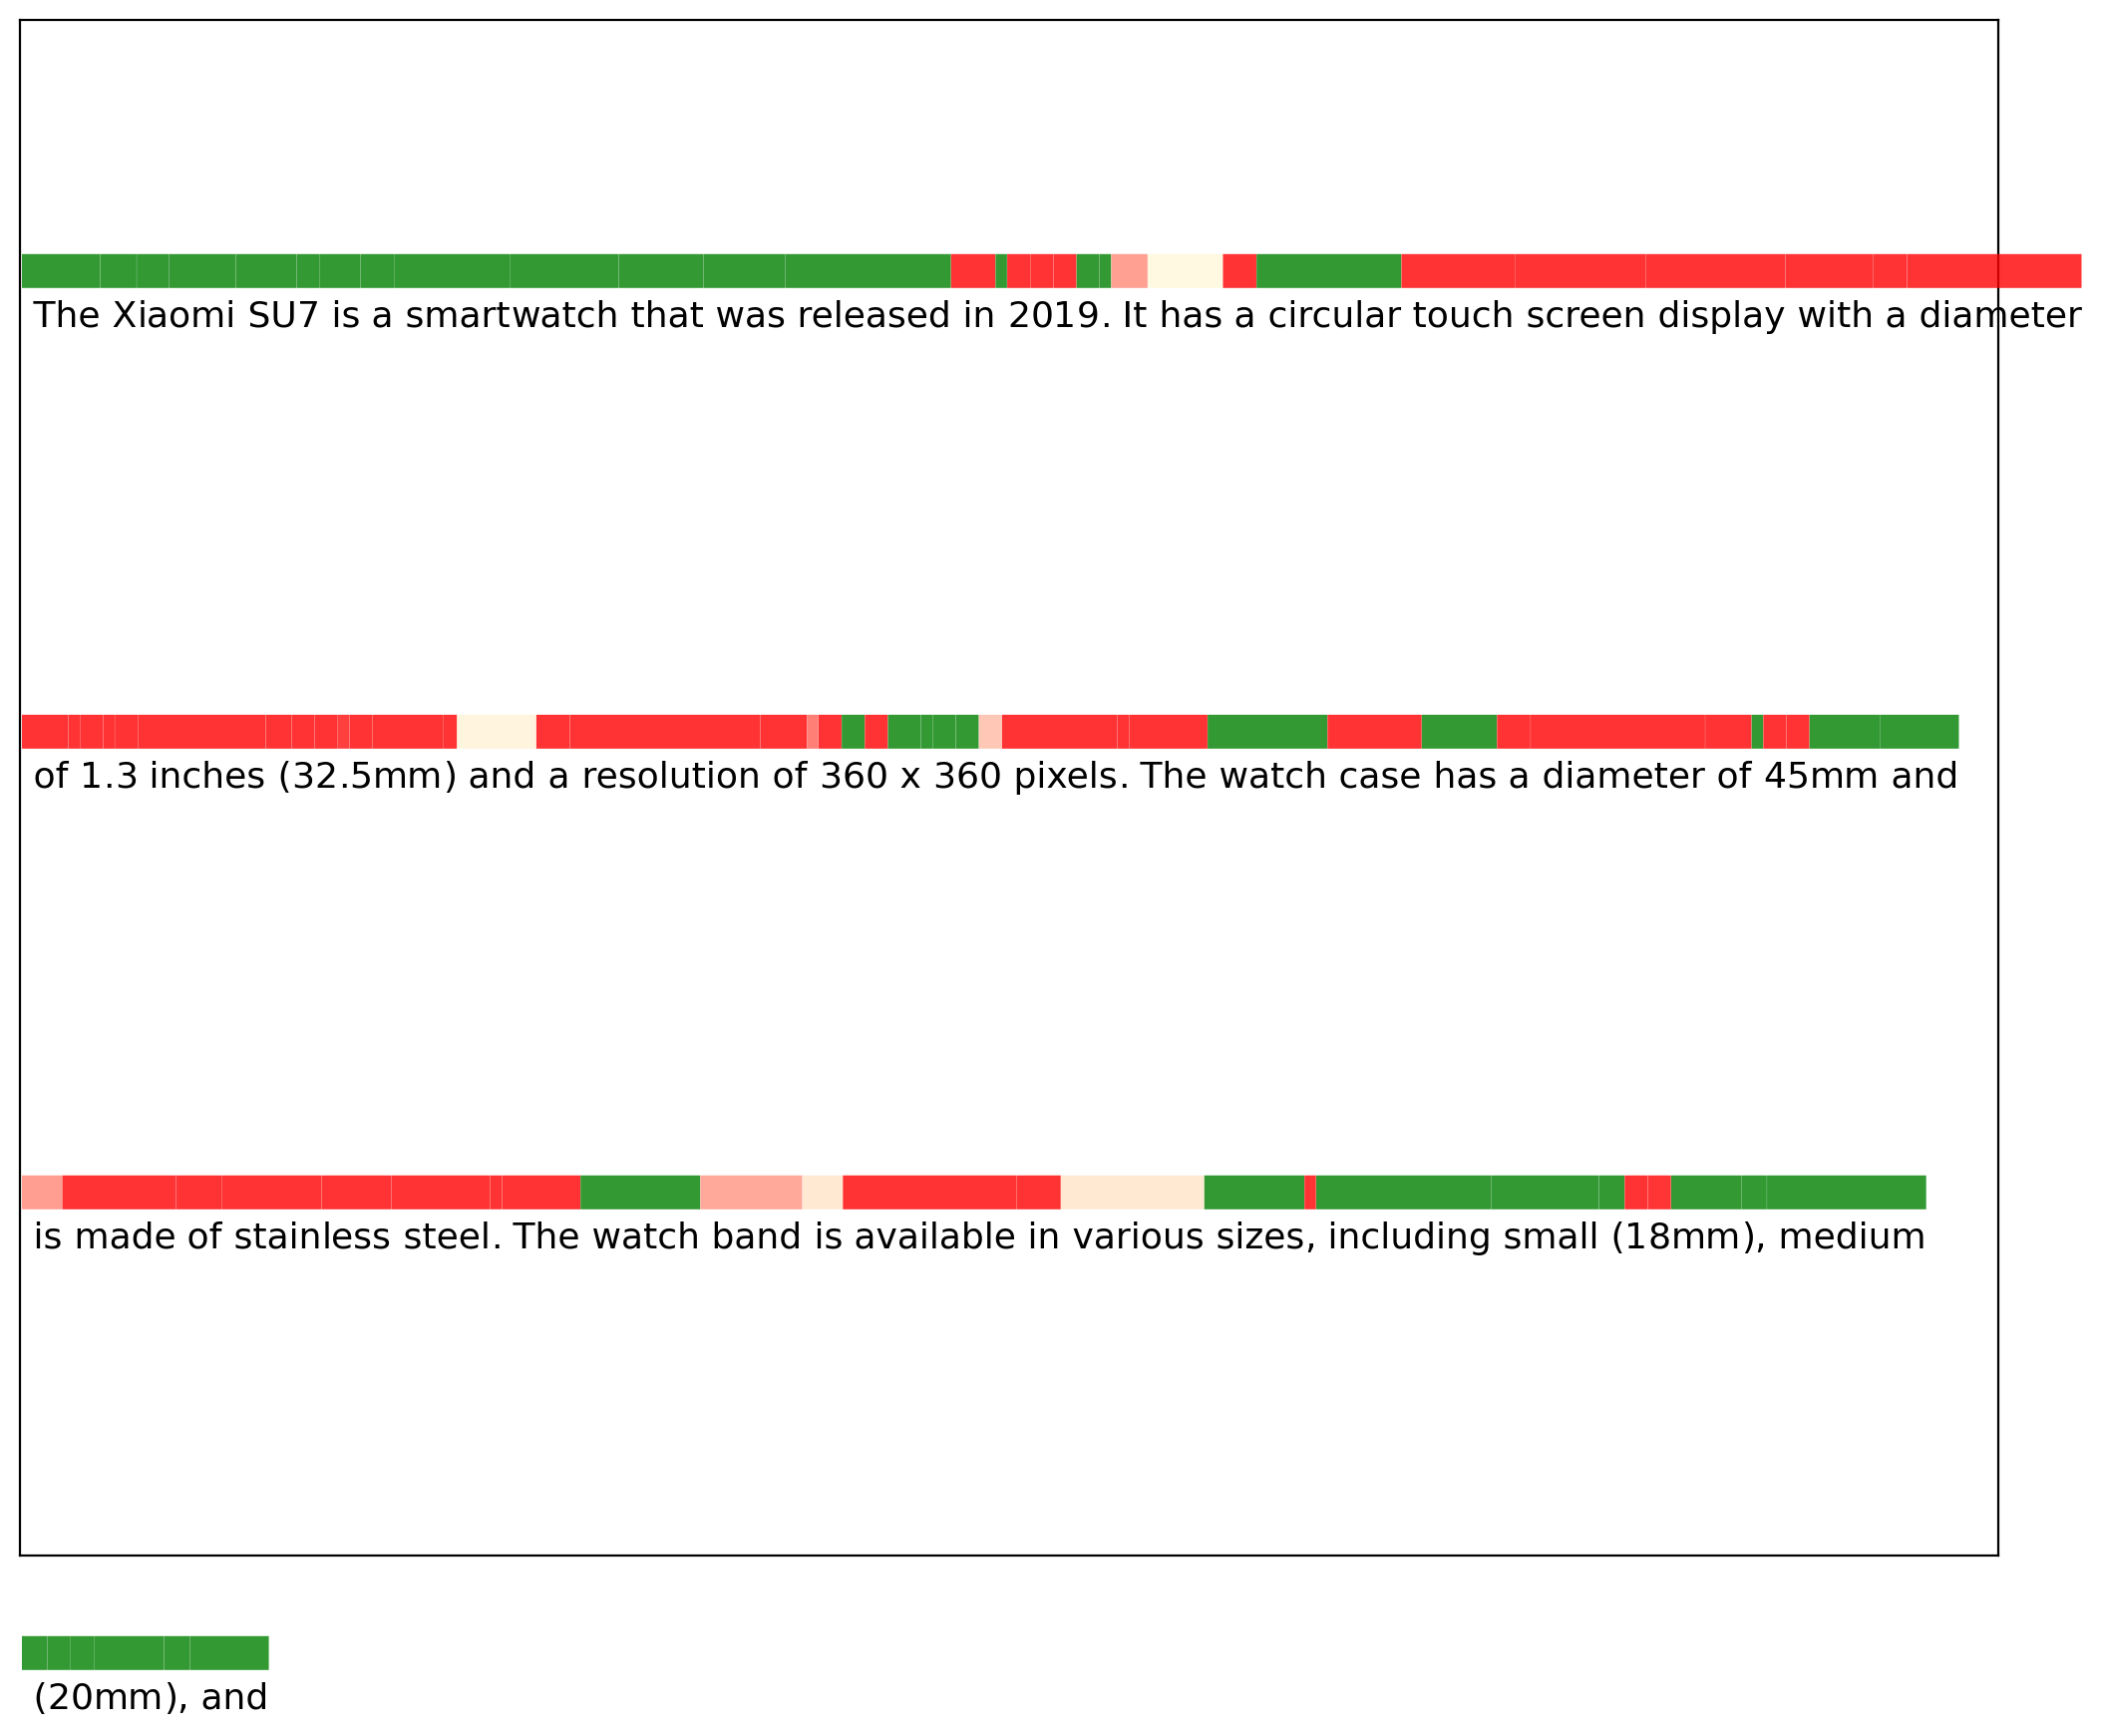

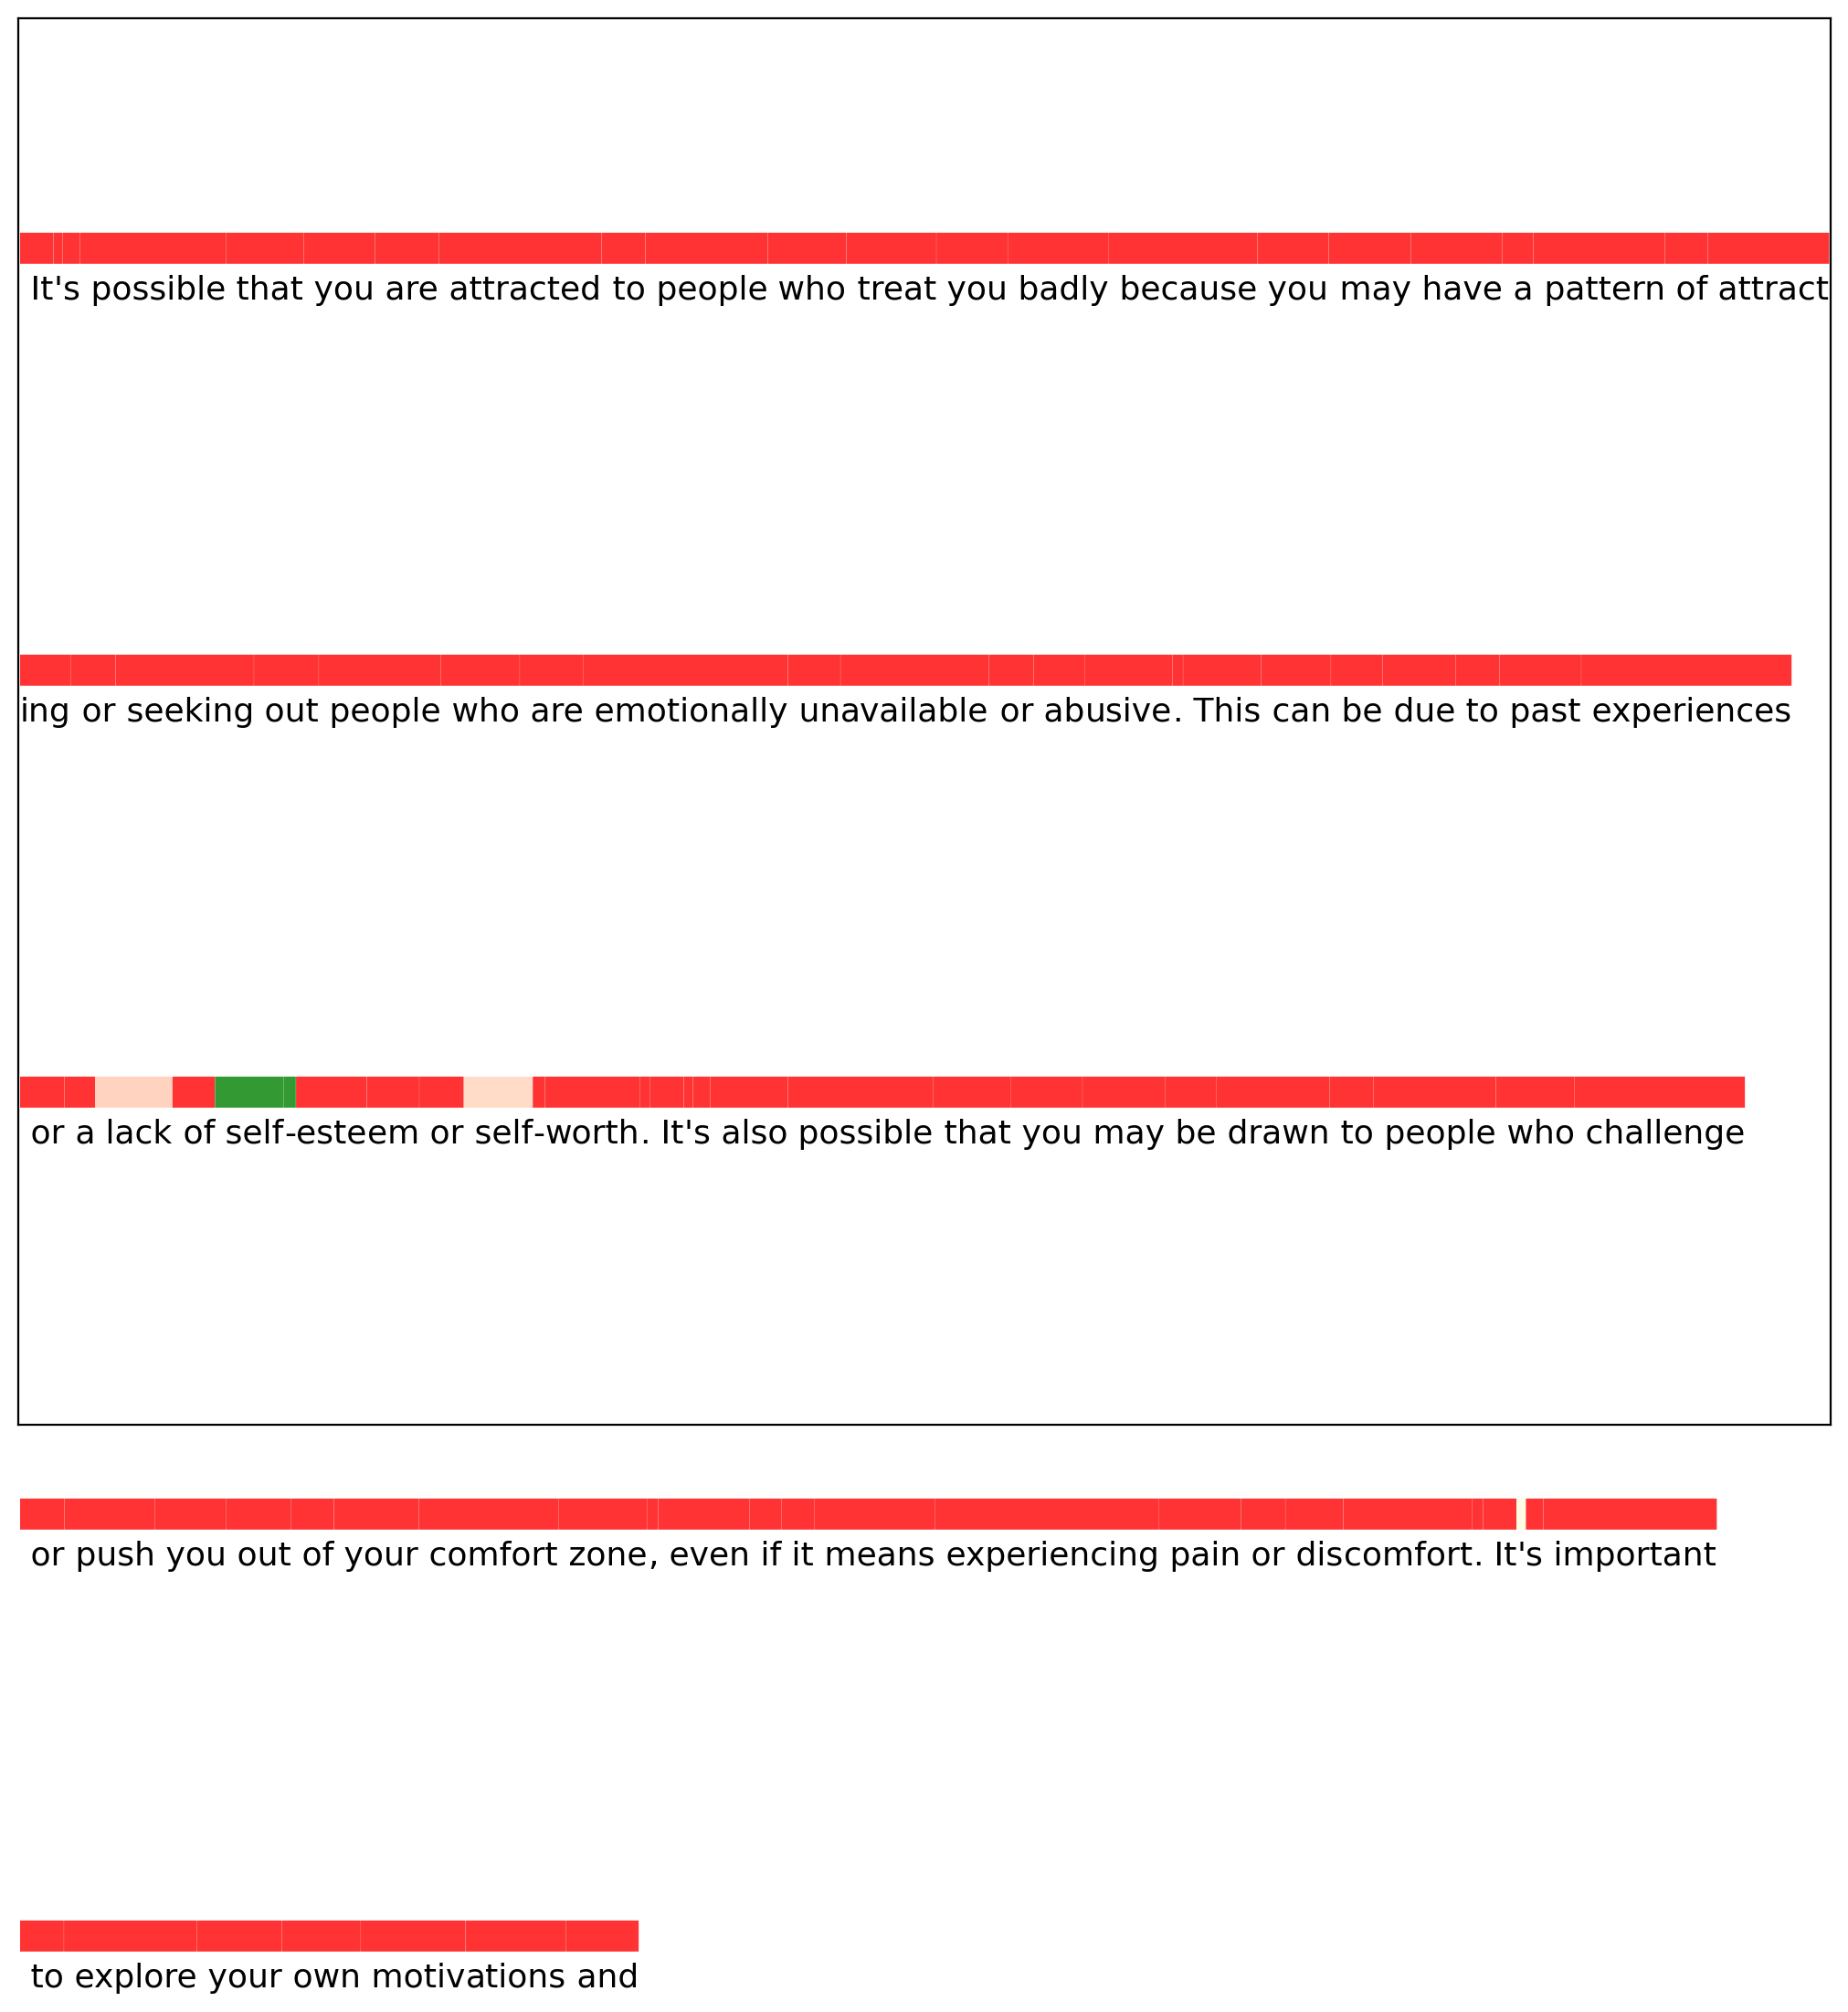

In [24]:
layers = range(-10, -25, -1)
THRESHOLD = 0.0

test_input = [
    # Unknown Questions
    "What are the dimensions of the Xiaomi SU7?",
    # Unanswerable Questions
    "Why am I attracted to people who treat me badly yet can’t help myself from feeling attracted to them again and again despite how much they hurt me?",
]
plot_result_given_q(
    test_input=test_input,
    user_tag=user_tag,
    assistant_tag=assistant_tag,
    honesty_rep_reader=confidence_rep_reader,
    hidden_layers=hidden_layers,
    layers=layers,
    rep_reading_pipeline=rep_reading_pipeline,
    tokenizer=tokenizer,
    model=model,
    # chosen_idx=0,
    THRESHOLD=THRESHOLD,
)

In [25]:
layer_id = list(range(-5, -18, -1))

block_name = "decoder_block"
control_method = "reading_vec"

rep_control_pipeline = pipeline(
    "rep-control",
    model=model,
    tokenizer=tokenizer,
    layers=layer_id,
    control_method=control_method)

In [26]:
test_input = [
    "Which breed of dog is bigger, Japanese Terrier or Cane Corso?",
]

inputs = [
    f"{user_tag} {i} {assistant_tag}" for i in test_input
]

In [27]:
coeff = -1
max_new_tokens = 40

activations = {}
for layer in layer_id:
    activations[layer] = torch.tensor(
        coeff * confidence_rep_reader.directions[layer] * confidence_rep_reader.direction_signs[layer]).to(
        model.device).half()

baseline_outputs = rep_control_pipeline(inputs, batch_size=4, max_new_tokens=max_new_tokens, do_sample=False)
control_outputs = rep_control_pipeline(inputs, activations=activations, batch_size=4, max_new_tokens=max_new_tokens,
                                       do_sample=False, repetition_penalty=1.1)

for i, s, p in zip(inputs, baseline_outputs, control_outputs):
    print("===== No Control =====")
    print(s[0]['generated_text'].replace(i, ""))
    print(f"===== - Confidence Control =====")
    print(p[0]['generated_text'].replace(i, ""))
    print()

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


===== No Control =====
 The Cane Corso is significantly larger than the Japanese Terrier. The Cane Corso is a breed of working dog that originated in Italy, and is known for its size, strength,
===== + Honesty Control =====
 The Cane Corso is generally considered to be a larger breed of dog than the Japanese Terrier.

